<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/TextClassifierDistilbertGerman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying News Articles with Distilbert

based on https://www.philschmid.de/bert-text-classification-in-a-different-language/ which applies `distilbert-base-german-cased` model on the [Germeval 2019](hhttps://projects.fzai.h-da.de/iggsa/projekt/) dataset to identify offensive language in German tweets.

Following we will use `distilbert-base-german-cased` on the 10k German News Articles dataset to classify 9 news topics.

## Prerequisites

In [1]:
# install simpletransformers
!pip install -q simpletransformers ipykernel==4.10 > /dev/null

# check installed version
!pip freeze | grep simpletransformers
# simpletransformers==0.61.4

ERROR: pydeck 0.6.2 has requirement ipykernel>=5.1.2; python_version >= "3.4", but you'll have ipykernel 4.10.0 which is incompatible.
ERROR: datasets 1.6.0 has requirement tqdm<4.50.0,>=4.27, but you'll have tqdm 4.60.0 which is incompatible.
simpletransformers==0.61.4


## Download Data

In [2]:
!mkdir -p data
!wget https://github.com/tblock/10kGNAD/blob/master/train.csv?raw=true -nv -O data/train.csv
!wget https://github.com/tblock/10kGNAD/blob/master/test.csv?raw=true -nv -O data/test.csv
!ls -lAh data

2021-04-23 21:08:24 URL:https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv [24405789/24405789] -> "data/train.csv" [1]
2021-04-23 21:08:25 URL:https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv [2755020/2755020] -> "data/test.csv" [1]
total 26M
-rw-r--r-- 1 root root 2.7M Apr 23 21:08 test.csv
-rw-r--r-- 1 root root  24M Apr 23 21:08 train.csv


## Import Data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
data_dir = Path("data/")

train_file = data_dir / 'train.csv'
test_file = data_dir / 'test.csv'

In [5]:
def load_file(filepath: Path) -> pd.DataFrame:
    f = pd.read_csv(filepath, sep=";", quotechar="'", names=['labels', 'text'])
    return f

In [6]:
train_df = load_file(data_dir / 'train.csv')
print(train_df.shape[0], 'articles')
display(train_df.head())

9245 articles


,labels,text
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,Inland,Estland sieht den künftigen österreichischen P...


## Analyse Dataset

* Imbalanced classes
* Text length

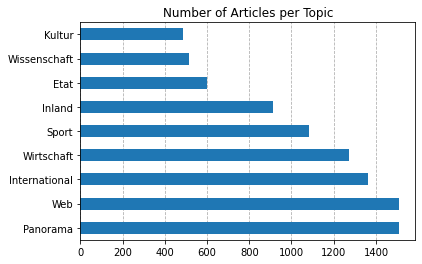

In [7]:
train_df.labels.value_counts().plot.barh(title="Number of Articles per Topic", zorder=2)
plt.gca().xaxis.grid(True, linestyle='--');

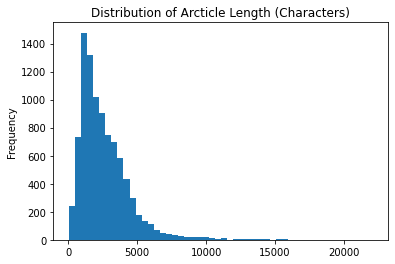

In [8]:
train_df.text.map(lambda x: len(x)).plot.hist(bins=50, title="Distribution of Arcticle Length (Characters)");

## Prepare for Model Training

Requirements of SimpleTransformers

* columns should be labeled `labels` and `text`
* labels must be int values starting at `0`

In [9]:
# compute weights for training (where least frequent class has weight 1.0)
train_weights_s = (train_df
                   .labels
                   .value_counts()
                   .pipe(lambda x: 1 / (x / x.min()))
)
train_weights_s

Panorama         0.321192
Web              0.321405
International    0.356618
Wirtschaft       0.381890
Sport            0.448659
Inland           0.531216
Etat             0.806988
Wissenschaft     0.939922
Kultur           1.000000
Name: labels, dtype: float64

In [10]:
# map label to integers
mapping_s = pd.Series(train_weights_s.index)
mapping_s

0         Panorama
1              Web
2    International
3       Wirtschaft
4            Sport
5           Inland
6             Etat
7     Wissenschaft
8           Kultur
dtype: object

In [11]:
# truncate text
#train_df.text = train_df.text.map(lambda x: x[:2000])

In [12]:
train_df.labels.replace(mapping_s.values, mapping_s.index, inplace=True)
display(train_df.head())

,labels,text
0,4,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,8,"Erfundene Bilder zu Filmen, die als verloren g..."
2,1,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,3,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,5,Estland sieht den künftigen österreichischen P...


In [13]:
# load test dataset
test_df = load_file(data_dir / 'test.csv')
test_df.labels.replace(mapping_s.values, mapping_s.index, inplace=True)
print(test_df.shape[0], 'articles')
display(test_df.head())

1028 articles


,labels,text
0,3,"Die Gewerkschaft GPA-djp lanciert den ""All-in-..."
1,4,Franzosen verteidigen 2:1-Führung – Kritische ...
2,1,Neues Video von Designern macht im Netz die Ru...
3,4,23-jähriger Brasilianer muss vier Spiele pausi...
4,2,Aufständische verwendeten Chemikalie bei Gefec...


## Train Model

In [14]:
import wandb

# initialize weights & biases logging
project_name = "german_news_article_classification"

In [15]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "fp16": False,
             "num_train_epochs": 4,
             "weight": train_weights_s.values,
             "evaluate_during_training": True,
             "overwrite_output_dir": True,
             "wandb_project": project_name}

# Create a ClassificationModel
model = ClassificationModel(
    #  "bert", "bert-base-german-cased",
    #  "bert", "bert-base-multilingual-cased",
     "distilbert", "distilbert-base-german-cased",
    #  "distilbert", "distilbert-base-multilingual-cased",
    # "distilbert", "dbmdz/distilbert-base-german-europeana-cased",
    # "electra", "german-nlp-group/electra-base-german-uncased", # ---
    # "electra", "deepset/gelectra-large",
     num_labels=9,
     args=train_args
 )

Downloading:   0%|          | 0.00/464 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/270M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-german-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias

Downloading:   0%|          | 0.00/240k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [16]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')

def precision_multiclass(labels, preds):
    return precision_score(labels, preds, average='macro')

def recall_multiclass(labels, preds):
    return recall_score(labels, preds, average='macro')

In [17]:
model.train_model(train_df, eval_df=test_df, f1=f1_multiclass, acc=accuracy_score, precision=precision_multiclass, recall=recall_multiclass)

  0%|          | 0/9245 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Running Epoch 0 of 4:   0%|          | 0/1156 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:760: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/1028 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1156 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1156 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1156 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

(4624,
 {'acc': [0.8706225680933852,
   0.8881322957198443,
   0.8891050583657587,
   0.8939688715953308,
   0.8988326848249028,
   0.9007782101167315],
  'eval_loss': [0.4645294696381388,
   0.49590017531850455,
   0.43435149574868903,
   0.5571602823342695,
   0.5867081598099863,
   0.5860908335420418],
  'f1': [0.8662897767633818,
   0.8823440609986946,
   0.8864398800176294,
   0.8911335037760365,
   0.8953506137260914,
   0.8977041902681034],
  'global_step': [1156, 2000, 2312, 3468, 4000, 4624],
  'mcc': [0.852633223907081,
   0.8721828693743535,
   0.8731455987986958,
   0.8784527759923064,
   0.8840458866146628,
   0.8862653974940554],
  'precision': [0.8709846027358739,
   0.8945375638205229,
   0.8882792926893814,
   0.8964125588870989,
   0.8987892501268335,
   0.900902572013337],
  'recall': [0.8676718897859707,
   0.8753474550845728,
   0.8859547567854263,
   0.8869531356344758,
   0.8929040015849695,
   0.8952982115505939],
  'train_loss': [1.0493175983428955,
   0.371879

In [18]:
result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score, precision=precision_multiclass, recall=recall_multiclass)

wandb.join()
wandb.finish()

  0%|          | 0/1028 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/129 [00:00<?, ?it/s]

Training loss,0.00085
lr,0.0
global_step,4624
_runtime,573
_timestamp,1619212727
_step,97
mcc,0.88627
train_loss,0.00454
eval_loss,0.58609
f1,0.8977
acc,0.90078


Training loss,█▆▄▂▂▂▄▃▂▂▂▁▁▁▁▁▃▂▁▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
lr,▂▅▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
mcc,▁▅▅▆██
train_loss,█▃▁▁▁▁
eval_loss,▂▄▁▇██
f1,▁▅▅▇▇█
acc,▁▅▅▆██


_runtime,6
_timestamp,1619212742
_step,2


_runtime,▁▆█
_timestamp,▁▆█
_step,▁▅█


In [19]:
pd.Series(result)

mcc          0.886265
f1           0.897704
acc          0.900778
precision    0.900903
recall       0.895298
eval_loss    0.586091
dtype: float64

In [20]:
pd.DataFrame(model_outputs, columns=mapping_s)

,Panorama,Web,International,Wirtschaft,Sport,Inland,Etat,Wissenschaft,Kultur
0,-1.625634,-2.440599,-2.018086,8.286459,-2.524823,1.493247,-2.022859,-2.551924,-2.574200
1,-1.094158,-1.641365,-1.405714,-0.572433,9.492938,-1.929654,-2.225247,-1.082678,-1.925012
2,-1.135883,9.105417,-1.418626,-0.736798,-2.523597,-1.180496,-1.128931,-0.890497,-1.611723
3,-0.675075,-1.516924,-0.855636,-0.568021,9.313907,-2.108312,-2.318083,-1.360998,-2.043038
4,-0.674335,-0.979039,9.073330,-0.948607,-2.497459,-2.241884,-2.417817,-1.929586,-1.573463
...,...,...,...,...,...,...,...,...,...
1023,-1.154204,8.400669,-1.526251,-0.188289,-2.823541,-1.425596,0.222315,-1.540803,-1.690194
1024,-1.035004,-2.206808,-1.898463,-0.704861,-2.883942,7.972064,-1.807924,-1.826320,-2.167278
1025,-0.828305,-1.684588,-1.490955,-0.620334,9.313402,-1.816113,-2.276847,-0.996199,-1.922634
1026,-0.931790,-1.581264,-1.660413,-0.671367,9.426061,-1.971804,-2.137308,-0.820833,-1.854695


In [21]:
pred_s = pd.DataFrame(model_outputs).idxmax(axis=1)
test_df.labels

0       3
1       4
2       1
3       4
4       2
       ..
1023    1
1024    5
1025    4
1026    4
1027    1
Name: labels, Length: 1028, dtype: int64

In [22]:
mapping_s.values

array(['Panorama', 'Web', 'International', 'Wirtschaft', 'Sport',
       'Inland', 'Etat', 'Wissenschaft', 'Kultur'], dtype=object)

In [24]:
import sklearn.metrics as skm
skm.confusion_matrix(test_df.labels, pred_s)

array([[143,   1,  11,   4,   0,   4,   1,   2,   2],
       [  0, 167,   0,   1,   0,   0,   0,   0,   0],
       [ 13,   1, 128,   5,   1,   1,   1,   1,   0],
       [  8,   1,   3, 127,   0,   2,   0,   0,   0],
       [  1,   0,   0,   0, 119,   0,   0,   0,   0],
       [  4,   0,   2,   4,   0,  87,   1,   2,   2],
       [  1,   2,   1,   2,   0,   2,  56,   0,   3],
       [  1,   0,   3,   1,   0,   1,   0,  51,   0],
       [  1,   0,   1,   0,   0,   1,   1,   2,  48]])

In [25]:
print(skm.classification_report(test_df.labels, pred_s, target_names=mapping_s.values))

               precision    recall  f1-score   support

     Panorama       0.83      0.85      0.84       168
          Web       0.97      0.99      0.98       168
International       0.86      0.85      0.85       151
   Wirtschaft       0.88      0.90      0.89       141
        Sport       0.99      0.99      0.99       120
       Inland       0.89      0.85      0.87       102
         Etat       0.93      0.84      0.88        67
 Wissenschaft       0.88      0.89      0.89        57
       Kultur       0.87      0.89      0.88        54

     accuracy                           0.90      1028
    macro avg       0.90      0.90      0.90      1028
 weighted avg       0.90      0.90      0.90      1028

